In [ ]:
# Cell 0. Notebook goal + assumptions (Plan A: one-shot MC selection)
# ---------------------------------------------------------------
# Goal:
#   From N generated completion PNGs (and their polygons), select the completion
#   that maximizes the target class evidence (here: 'cow') subject to hard validity
#   checks (no perceptual prior).
#
# Inputs you said you already have:
#   - CASE_JSONL: a jsonl file with one (or more) case rows containing:
#       shape_contour_xy (normalized), occluder_rect_xy (normalized), etc.
#   - SHAPES_XY_NPZ: shapes_xy.npz saved via save_xy_npz(out_files, polygons, base_grid, matlab_1_indexed=True)
#   - COMPLETION PNGs: out_files from shapes_xy.npz exist on disk
#   - OCCLUDED_PNG: baseline occluded image (same size/crop as completions)
#   - ONNX_PATH: classification model path (onnx)
#   - CLASS_NAMES_JSON: canonical class list saved from master_lib.mat
#
# Assumptions:
#   - Images are binary silhouettes: black shape on white background (RGB or grayscale).
#   - All images share identical canvas size and alignment.
#   - We will optimize target='cow' (not dog).
#
# Output artifacts:
#   - a ranked table (DataFrame) with evidence + validity per completion
#   - best completion path + copied image into results folder
#   - JSON summary of the best completion
#
# NOTE:
#   This notebook is structured as cells you can paste directly into a .ipynb.


# Setting Paths / Imports

In [1]:
# Cell 0. Choose case folder
from pathlib import Path

ROOT = Path("..").resolve()

CASE_ID  = "cow_220_4"
CASE_DIR = ROOT / "data" / "cases" / CASE_ID

assert CASE_DIR.exists(), f"Missing CASE_DIR: {CASE_DIR}"
print("CASE_DIR:", CASE_DIR)


CASE_DIR: /Users/I743312/Documents/monte-carlo-selection/data/cases/cow_220_4


In [2]:
# Cell 1. Case paths
CASE_JSONL      = CASE_DIR / f"{CASE_ID}.jsonl"
OCCLUDED_PNG    = CASE_DIR / "occluded.png"  # or CASE_DIR/"occluded"/"occluded.png" if you prefer
SHAPES_XY_NPZ   = CASE_DIR / "generated" / "shapes_xy.npz"
COMPLETIONS_DIR = CASE_DIR / "generated" / "completions"
METAS_JSONL     = CASE_DIR / "generated" / "shapes_meta.jsonl"  # optional

for p in [CASE_JSONL, OCCLUDED_PNG, SHAPES_XY_NPZ, COMPLETIONS_DIR]:
    assert p.exists(), f"Missing: {p}"

OUT_DIR = CASE_DIR / "results" / "planA"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)


OUT_DIR: /Users/I743312/Documents/monte-carlo-selection/data/cases/cow_220_4/results/planA


# Determining Target Class based on occluder logits

In [3]:
# Cell 2 (REVISED). Load canonical class list (JSONL-safe)
import json
from pathlib import Path

CLASS_NAMES_JSON = ROOT / "data" / "class_names.jsonl"

with CLASS_NAMES_JSON.open("r", encoding="utf-8") as f:
    classes = [json.loads(line)["class_name"] for line in f if line.strip()]

print("Loaded class list:", len(classes))


Loaded class list: 54


In [4]:
# Cell 3 Run ONNX on occluded baseline and set target = argmax logit
import onnxruntime as ort
import numpy as np
from PIL import Image

ONNX_PATH = ROOT / "data" / "models" / "resnet50_geirhos_tl_with_feats.onnx"

sess = ort.InferenceSession(str(ONNX_PATH), providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

IMG_SIZE = 224

def preprocess_imagenet(img: Image.Image, size: int = 224) -> np.ndarray:
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize((size, size), resample=Image.BILINEAR)
    x = (np.asarray(img).astype(np.float32) / 255.0)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    x = (x - mean[None, None, :]) / std[None, None, :]
    x = np.transpose(x, (2, 0, 1))[None, ...]
    return x.astype(np.float32)

def infer_logits(path: Path) -> np.ndarray:
    img = Image.open(path)
    x = preprocess_imagenet(img, IMG_SIZE)
    y = sess.run([output_name], {input_name: x})[0]
    return np.asarray(y).reshape(-1)

def softmax(logits: np.ndarray) -> np.ndarray:
    z = logits - np.max(logits)
    e = np.exp(z)
    return e / (np.sum(e) + 1e-12)

# Baseline logits
occ_logits = infer_logits(OCCLUDED_PNG)
occ_prob = softmax(occ_logits)

target_idx = int(np.argmax(occ_logits))
TARGET_CLASS = classes[target_idx]

print("Target selected from occluded baseline:")
print("  target_idx:", target_idx)
print("  TARGET_CLASS:", TARGET_CLASS)
print("  occ_target_logit:", float(occ_logits[target_idx]))
print("  occ_target_prob :", float(occ_prob[target_idx]))

# Optional: inspect top-10 baseline classes
top10 = np.argsort(-occ_logits)[:10]
print("\nTop-10 baseline classes:")
for r, j in enumerate(top10, start=1):
    print(f"  {r:02d}. {classes[int(j)]:>12s}  logit={float(occ_logits[j]): .4f}  prob={float(occ_prob[j]): .4f}")


Target selected from occluded baseline:
  target_idx: 7
  TARGET_CLASS: bull
  occ_target_logit: 6.861343860626221
  occ_target_prob : 0.3898751735687256

Top-10 baseline classes:
  01.         bull  logit= 6.8613  prob= 0.3899
  02.          cow  logit= 5.7569  prob= 0.1292
  03.         goat  logit= 5.4936  prob= 0.0993
  04.       coyote  logit= 5.4632  prob= 0.0963
  05.        sheep  logit= 5.4599  prob= 0.0960
  06.         wolf  logit= 5.0269  prob= 0.0623
  07.        horse  logit= 4.8007  prob= 0.0497
  08.         deer  logit= 3.5568  prob= 0.0143
  09.          pig  logit= 3.5321  prob= 0.0140
  10.          dog  logit= 3.4291  prob= 0.0126


# Loading Shapes / Inference over 10k PNGs

In [5]:
# Cell 3. Load shapes_xy.npz and resolve PNG paths
import numpy as np
from pathlib import Path

z = np.load(SHAPES_XY_NPZ, allow_pickle=True)
out_files_raw = z["out_files"].tolist()
polygons_xy   = z["polygons"]
base_grid     = int(z["base_grid"]) if "base_grid" in z else None
matlab_1_indexed = bool(z["matlab_1_indexed"]) if "matlab_1_indexed" in z else False

def resolve_png_path(p: str) -> Path:
    pth = Path(p)
    if pth.exists():
        return pth
    # try: use filename inside completions dir
    return (COMPLETIONS_DIR / pth.name)

png_paths = [resolve_png_path(p) for p in out_files_raw]

missing = sum(1 for p in png_paths if not p.exists())
print("N:", len(png_paths))
print("Missing PNGs:", missing)
print("Example:", png_paths[0])


N: 10000
Missing PNGs: 0
Example: /Users/I743312/Documents/occlusion-study/data/generated_images/random_segments/completion_0001_00001.png


In [10]:
# Cell X. No geometry filtering: treat all samples as valid
valid_poly = np.ones(N, dtype=bool)


In [8]:
# Cell 5. ONNX inference: baseline + completions
import onnxruntime as ort
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

ONNX_PATH = ROOT / "data" / "models" / "resnet50_geirhos_tl_with_feats.onnx"

sess = ort.InferenceSession(str(ONNX_PATH), providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

IMG_SIZE = 224

def preprocess_imagenet(img: Image.Image, size: int = 224) -> np.ndarray:
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize((size, size), resample=Image.BILINEAR)
    x = (np.asarray(img).astype(np.float32) / 255.0)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    x = (x - mean[None, None, :]) / std[None, None, :]
    x = np.transpose(x, (2, 0, 1))[None, ...]
    return x.astype(np.float32)

def infer_logits(path: Path) -> np.ndarray:
    img = Image.open(path)
    x = preprocess_imagenet(img, IMG_SIZE)
    y = sess.run([output_name], {input_name: x})[0]
    return np.asarray(y).reshape(-1)

def softmax(logits: np.ndarray) -> np.ndarray:
    z = logits - np.max(logits)
    e = np.exp(z)
    return e / (np.sum(e) + 1e-12)

# Baseline
occ_logits = infer_logits(OCCLUDED_PNG)
occ_prob = softmax(occ_logits)

occ_tlog = float(occ_logits[target_idx])
occ_tpr  = float(occ_prob[target_idx])
print("Baseline:", TARGET_CLASS, "logit", occ_tlog, "prob", occ_tpr)

# Completions
N = len(png_paths)
tlog = np.full(N, np.nan, dtype=np.float64)
tpr  = np.full(N, np.nan, dtype=np.float64)
tmar = np.full(N, np.nan, dtype=np.float64)

for i in tqdm(range(N)):
    if not png_paths[i].exists():
        continue
    logits = infer_logits(png_paths[i])
    prob = softmax(logits)
    tlog[i] = float(logits[target_idx])
    tpr[i]  = float(prob[target_idx])
    tmar[i] = float(tlog[i] - np.max(np.delete(logits, target_idx)))


Baseline: bull logit 6.861343860626221 prob 0.3898751735687256


  0%|          | 0/10000 [00:00<?, ?it/s]

# Monte Carlo Selection

In [11]:
# Cell 6. Rank + select best completion, export artifacts
import pandas as pd
import shutil
import json

df = pd.DataFrame({
    "i": np.arange(N, dtype=int),
    "png_path": [str(p) for p in png_paths],
    "valid_poly": valid_poly,
    "target_logit": tlog,
    "target_prob": tpr,
    "target_margin": tmar,
})

df = df[df["valid_poly"]].copy()
df = df[np.isfinite(df["target_logit"])].copy()

# Require improvement over baseline (recommended)
df_imp = df[df["target_logit"] > occ_tlog].copy()

if len(df_imp) == 0:
    raise RuntimeError("No completion beats baseline on target_logit. "
                       "Try removing the improvement filter or verify preprocessing.")

df_rank = df_imp.sort_values(
    ["target_logit", "target_margin", "target_prob"],
    ascending=[False, False, False],
).reset_index(drop=True)

best = df_rank.iloc[0].to_dict()
best_path = Path(best["png_path"])

print("BEST:", best["i"], best_path.name, "logit", best["target_logit"], "prob", best["target_prob"])

# Save ranking
rank_csv = OUT_DIR / f"ranking_{TARGET_CLASS}.csv"
df_rank.to_csv(rank_csv, index=False)

# Copy baseline + best + topK
TOP_K = 10
top_dir = OUT_DIR / f"top_{TOP_K:02d}"
top_dir.mkdir(parents=True, exist_ok=True)

shutil.copy2(OCCLUDED_PNG, OUT_DIR / "baseline_occluded.png")
shutil.copy2(best_path, OUT_DIR / f"best_{TARGET_CLASS}_i{int(best['i']):05d}.png")

for r in range(min(TOP_K, len(df_rank))):
    src = Path(df_rank.loc[r, "png_path"])
    dst = top_dir / f"rank_{r+1:02d}_i{int(df_rank.loc[r,'i']):05d}.png"
    shutil.copy2(src, dst)

summary = {
    "case_id": CASE_ID,
    "target_class": TARGET_CLASS,
    "target_idx": int(target_idx),
    "baseline": {"logit": occ_tlog, "prob": occ_tpr, "png": str(OCCLUDED_PNG)},
    "best": {
        "i": int(best["i"]),
        "png": str(best_path),
        "logit": float(best["target_logit"]),
        "prob": float(best["target_prob"]),
        "margin": float(best["target_margin"]),
    },
    "counts": {"N_total": int(N), "N_valid_poly": int(valid_poly.sum()), "N_scored": int(np.isfinite(tlog).sum())},
}

(OUT_DIR / "best_summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")

print("Saved:", rank_csv)
print("Saved:", OUT_DIR / "best_summary.json")
print("Copied images to:", OUT_DIR)


BEST: 9121 completion_0001_09122.png logit 8.501516342163086 prob 0.7382082343101501
Saved: /Users/I743312/Documents/monte-carlo-selection/data/cases/cow_220_4/results/planA/ranking_bull.csv
Saved: /Users/I743312/Documents/monte-carlo-selection/data/cases/cow_220_4/results/planA/best_summary.json
Copied images to: /Users/I743312/Documents/monte-carlo-selection/data/cases/cow_220_4/results/planA


# Averaging

In [19]:
# Cell. Choose top-K set and define activation-informed weights
# ------------------------------------------------------------
# Assumes you have:
#   - df_rank: ranked DataFrame (best first) with columns: i, target_logit
#   - polygons_xy: polygons for all N
#   - matlab_1_indexed: bool
#
# This outputs:
#   - top_idx: list of global indices
#   - weights: (K,) nonnegative weights summing to 1

import numpy as np

K_CONS = 100  # top-K completions used for consensus
top = df_rank.head(K_CONS).copy()

top_idx = top["i"].astype(int).to_list()
logits = top["target_logit"].to_numpy(dtype=np.float64)

# Activation-informed weights
# Option 1: softmax over logits (temperature controls peakiness)
TEMP = 1.0
z = (logits - logits.max()) / max(1e-12, TEMP)
w = np.exp(z)
weights = w / (w.sum() + 1e-12)

print("Top-K for consensus:", len(top_idx))
print("Weights: min/mean/max =", float(weights.min()), float(weights.mean()), float(weights.max()))


Top-K for consensus: 100
Weights: min/mean/max = 0.008511737787625878 0.009999999999999799 0.020359117325248855


In [20]:
# Cell. Rasterize polygons into a weighted occupancy map S(p)
# ----------------------------------------------------------
# We build S over the full image canvas (H x W) based on PNG size.
#
# Requires:
#   - polygons_xy (global)
#   - top_idx, weights
#   - png_paths (global) or another way to get H,W
#   - matlab_1_indexed
#   - invert_y (optional) is already handled at generation; polygons are pixel coords.
#
# Output:
#   - S: (H,W) weighted occupancy fraction in [0,1]
#   - count_map: unweighted occupancy count (diagnostic)

import numpy as np
from PIL import Image, ImageDraw

# Get canvas size from any existing completion PNG
from pathlib import Path

any_png = None
for p in png_paths:
    if Path(p).exists():
        any_png = Path(p)
        break
if any_png is None:
    raise FileNotFoundError("Could not find any completion PNG to infer image size.")

W_img, H_img = Image.open(any_png).size
print("Canvas size:", H_img, W_img)

def rasterize_polygon_mask(poly_xy: np.ndarray, H: int, W: int) -> np.ndarray:
    pts = np.asarray(poly_xy, dtype=np.float64)
    if matlab_1_indexed:
        pts = pts - 1.0
    pts = pts.reshape(-1, 2)

    # Ensure closed
    if pts.shape[0] >= 2 and (not np.allclose(pts[0], pts[-1])):
        pts = np.vstack([pts, pts[0]])

    # PIL expects (x,y) tuples
    xy = [(float(x), float(y)) for x, y in pts]
    img = Image.new("L", (W, H), 0)
    draw = ImageDraw.Draw(img)
    draw.polygon(xy, outline=1, fill=1)
    return np.asarray(img, dtype=np.uint8)

S = np.zeros((H_img, W_img), dtype=np.float64)
count_map = np.zeros((H_img, W_img), dtype=np.float64)

for idx, wi in zip(top_idx, weights):
    mask = rasterize_polygon_mask(polygons_xy[idx], H_img, W_img)
    S += wi * mask
    count_map += mask

# S already in [0,1] because weights sum to 1
print("S stats: min/mean/max =", float(S.min()), float(S.mean()), float(S.max()))


Canvas size: 600 900
S stats: min/mean/max = 0.0 0.04552430255818489 0.9999999999999793


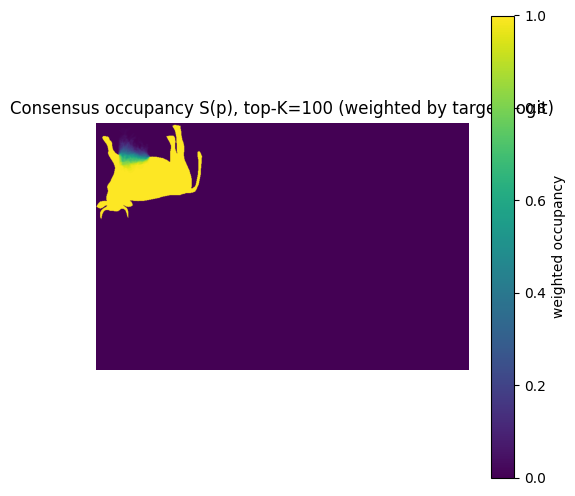

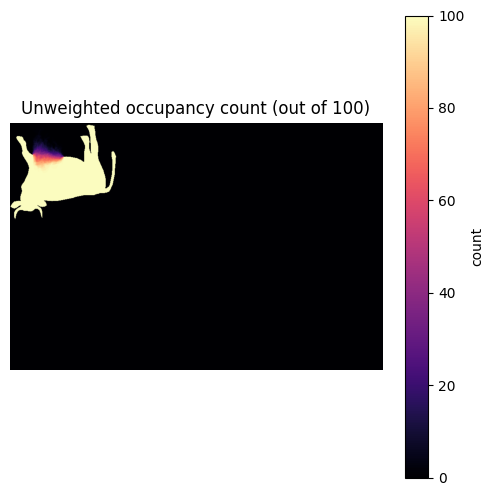

In [21]:
# Cell. Visualize consensus heatmap S(p) and uncertainty bands
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 6))
plt.title(f"Consensus occupancy S(p), top-K={K_CONS} (weighted by target_logit)")
plt.imshow(S, cmap="viridis")
plt.colorbar(label="weighted occupancy")
plt.axis("off")
plt.show()

# Optional: show count-based (unweighted) too
plt.figure(figsize=(6, 6))
plt.title(f"Unweighted occupancy count (out of {K_CONS})")
plt.imshow(count_map, cmap="magma")
plt.colorbar(label="count")
plt.axis("off")
plt.show()


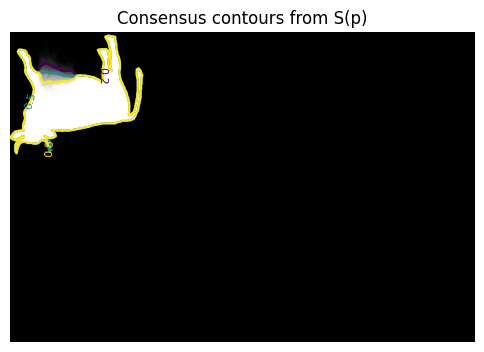

In [22]:
# Cell. Extract consensus contours at multiple levels (e.g., 0.2 / 0.5 / 0.8)
# --------------------------------------------------------------------------
# This turns the consensus field into a "consensus shape boundary" visualization.
# Note: This is a visualization contour, not guaranteed to be a valid simple polygon.

import numpy as np
import matplotlib.pyplot as plt

levels = [0.2, 0.5, 0.8]

plt.figure(figsize=(6, 6))
plt.title("Consensus contours from S(p)")
plt.imshow(S, cmap="gray")
cs = plt.contour(S, levels=levels)
plt.clabel(cs, inline=True, fontsize=8)
plt.axis("off")
plt.show()
